In [1]:
import numpy as np
import torch
from utils import train, Experiment
from models import BAEMNet 

e:\python_3.7\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the tabular Dataset

In [2]:
# Lets load the Adult Dataset
exp = Experiment(dataset="adult")

In [3]:
print("Adult Dataset:")
print(f"Trainset:  {exp.x_train.shape[0]} Samples and {exp.x_train.shape[1]} Features")
print(f"Testset:  {exp.x_test.shape[0]} Samples")

Adult Dataset:
Trainset:  36177 Samples and 13 Features
Testset:  9045 Samples


# Initialize the Baemnet model

In [4]:
# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  


baemnet = BAEMNet(inp_shape=exp.x_train.shape[1],    # Specify the number of features
                  num_feats=exp.num_feats,           # Number of numerical features
                  cat_feats=exp.cat_feats,           # Number of categorical features
                  units=100,                         # Number of neurons per dense layer
                  out_shape=2,                       # Number of classes
                  vocab=np.ones(len(exp.cat_feats), dtype="int") * 2 if exp.cat_feats is not None else None,  
                                                     # Set Vocabulary length for each Categorical feature
                  embed_dims=10,                     # Embedding dimensions
                  baseline="zeros").to(device)       # Set the unique embedding baseline 
                                                     # (zeros, ones, random or a specific tensor)

    
# Call the train function to train the model
# Select the subset policy: (random or None)
#  - random means that for each iteration a random subset of features is sampled
#  - None means that there is no subset and baemnet is trained like a normal NN.
baemnet = train(model=baemnet,
                x_train=exp.x_train, 
                y_train=exp.y_train, 
                x_test=exp.x_test, 
                y_test=exp.y_test,
                cat_feats=exp.cat_feats,
                num_feats=exp.num_feats,
                epochs=100, 
                subset="random",       
                device=device)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69
Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79
Epoch:  80
Epoch:  81
Epoch:  82
Epoch:  83
Epoch:  84
Epoch:  85
Epoch:  86
Epoch:  87
Epoch:  88
Epoch:  89
Epoch:  90
Epoch:  9

# Using subsets to make predictions with less features

In [5]:
sub = torch.tensor([0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1])
preds = baemnet.predict(exp.x_test[0:1].to(device), subset=None)
sub_preds = baemnet.predict(exp.x_test[0:1].to(device), subset=sub.to(device))
print("Prediction with all features: ", preds.detach().cpu().numpy())
print("Prediction with subset of features: ", sub_preds.detach().cpu().numpy())

Prediction with all features:  [[9.991710e-01 8.289574e-04]]
Prediction with subset of features:  [[0.9662163  0.03378366]]


# Calculate Attributions

In [6]:
# Lets calculate the IG attributions with the help of BAEMNet
# We are using the Captum Library and the appropriate format
# To calculate the attributions of BAEMNet we use 2 inputs: the dataset input and the subset input
# The integration will be on the subset input
# Thats why we set the baseline as a zero subset and the input as the ones subset

from captum.attr import IntegratedGradients

ig = IntegratedGradients(forward_func=baemnet)


attrs = ig.attribute(inputs=(exp.x_test.to(device), 
                             torch.ones(exp.x_test.shape).to(device)),   # ones subest = all features present
                     target=exp.y_test.to(device), 
                     baselines=(exp.x_test.to(device), 
                                torch.zeros(exp.x_test.shape).to(device)),  # zeros subset = all features absent 
                     n_steps=35, 
                     internal_batch_size=200, 
                     return_convergence_delta=True)


print(attrs[0][1])

e:\python_3.7\lib\site-packages\captum\attr\_utils\batching.py:48: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 9045 equal to the number of examples.
  % num_examples


tensor([[ 4.2297e-01,  6.8718e-03,  2.6275e-01,  ...,  2.4179e-01,
          1.9552e-01,  1.7600e-02],
        [-2.0773e-01,  1.3520e-03, -3.1941e-01,  ...,  1.6381e-02,
         -1.7897e-02,  4.2969e-03],
        [ 2.5415e-01,  2.2339e-02,  6.5351e-01,  ...,  1.4266e-01,
          8.6669e-03,  9.4558e-03],
        ...,
        [-2.6073e-01,  1.1191e-02, -1.6681e-01,  ..., -1.3302e-01,
          9.0209e-02, -9.9643e-03],
        [-2.8164e-01,  3.8948e-04,  7.1313e-02,  ..., -5.0192e-03,
         -1.6613e-02,  9.9175e-03],
        [-2.6526e-01, -1.9601e-02, -1.6747e-01,  ..., -9.0509e-02,
         -7.7006e-03, -2.7381e-03]], device='cuda:0', dtype=torch.float64)


# Plot Attributions

In [7]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
def plot_attributions(attr, feature_names=None):
    fig, ax = plt.subplots()
    if feature_names is None:
        df = pd.DataFrame({'Features': [f"feat_{i}" for i, _ in enumerate(attr)], 
                           'Attribution': [float(format(i, ".4f")) for i in attr]})
    else:
        df = pd.DataFrame({'Features': [f"{feature_names[i]}" for i, _ in enumerate(attr)], 
                           'Attribution': [float(format(i, ".4f")) for i in attr]})
    
    sns.barplot(data=df, x="Attribution", y="Features")
    ax.bar_label(ax.containers[0])
    plt.xlim(-1, 1)
    sns.despine()
    return fig, ax

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Attribution', ylabel='Features'>)

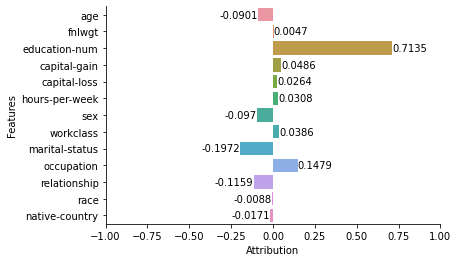

In [9]:
# Lets plot the attributions of a sample
sample = 310

plot_attributions(attrs[0][1][sample], exp.feature_names)